In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
housing = pd.read_excel('Monroe_County_house_price.xlsx', index_col=0)
# del 2 features not needed
del housing['detail_url']
del housing['location']
# drop row with certain value and NaN
housing = housing[~housing.bathrooms.str.contains("None")]
housing = housing[~housing.bedrooms.str.contains("None")]
housing = housing[~housing.bedrooms.str.contains("Studio")]
housing = housing[~housing.space.str.contains("None")]
# 一定要这样写,不然去不掉Nan
housing = housing.dropna()
# Convert String to Integer in Pandas DataFrame
# https://www.geeksforgeeks.org/how-to-convert-string-to-integer-in-pandas-dataframe/
housing['bedrooms'] = housing['bedrooms'].astype(float)
housing['bathrooms'] = housing['bathrooms'].astype(float)
housing['space'] = housing['space'].astype(float)

## 1. Explore the data
* Size, data types, missing values, ...

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885 entries, 0 to 1139
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   885 non-null    float64
 1   longitude  885 non-null    float64
 2   bedrooms   885 non-null    float64
 3   bathrooms  885 non-null    float64
 4   space      885 non-null    float64
 5   price      885 non-null    float64
dtypes: float64(6)
memory usage: 48.4 KB


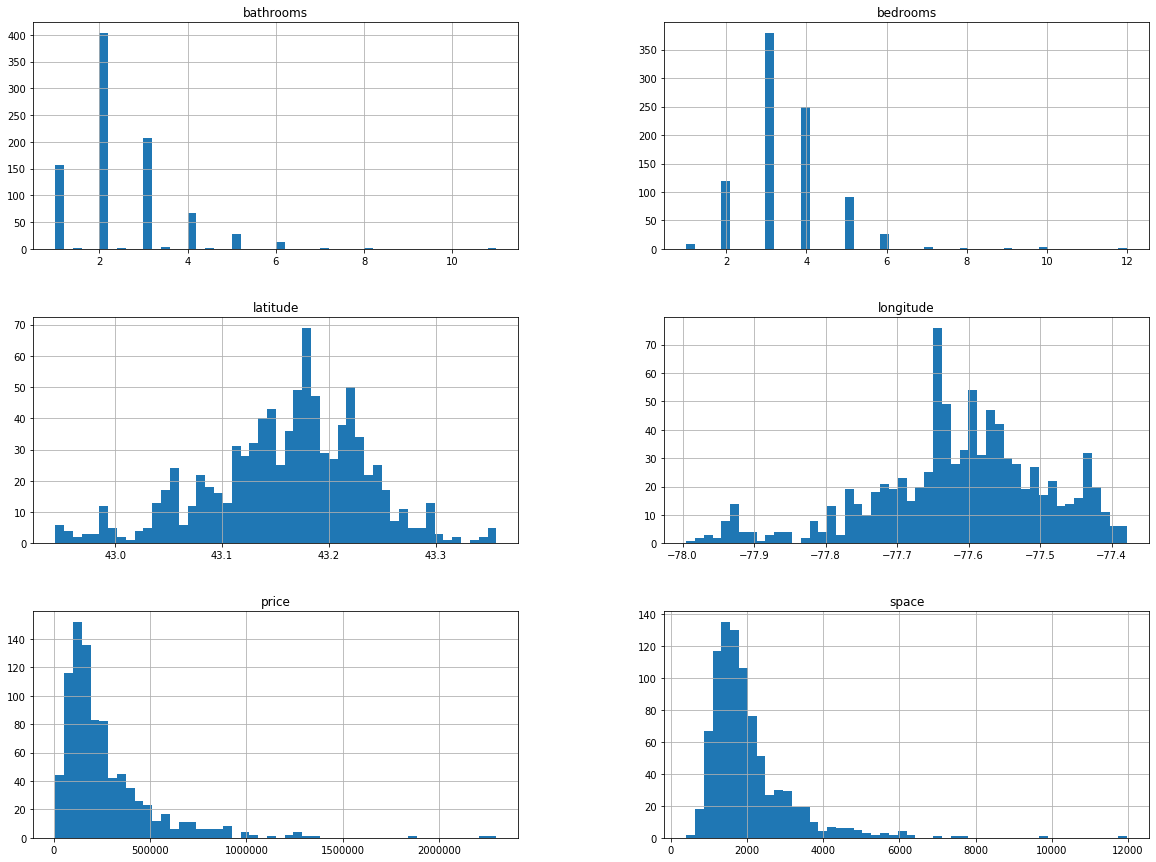

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

## 2. Create test set

* Test set - data that was not used in constructing the model and only used for final evaluations
* Train set - data used to construct a model

In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=1) 
# always return the same result each time
# https://www.cnblogs.com/SupremeBoy/p/12247864.html
#test 20%, train 80%

In [6]:
print(housing.shape, train_set.shape, test_set.shape)

(885, 6) (708, 6) (177, 6)


In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708 entries, 120 to 37
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   708 non-null    float64
 1   longitude  708 non-null    float64
 2   bedrooms   708 non-null    float64
 3   bathrooms  708 non-null    float64
 4   space      708 non-null    float64
 5   price      708 non-null    float64
dtypes: float64(6)
memory usage: 38.7 KB


## 3. Explore data to gain insights

* Only use training set from now on
* Use sample if data set is too large

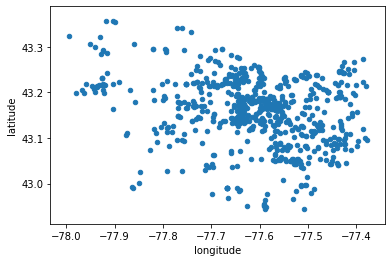

In [8]:
housing = train_set.copy()
housing.plot(kind='scatter', x='longitude', y='latitude');

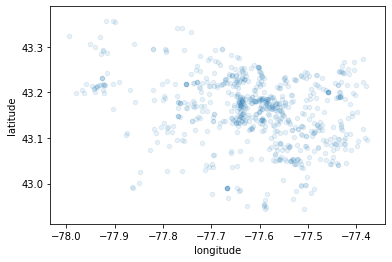

In [9]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1);

In [10]:
housing.head()

,latitude,longitude,bedrooms,bathrooms,space,price
120,43.186573,-77.49522,3.0,3.0,2197.0,289900.0
279,43.181202,-77.73704,3.0,2.0,1594.0,199900.0
893,43.165504,-77.56760,4.0,1.0,1448.0,50000.0
506,43.232430,-77.92584,3.0,2.0,1254.0,79900.0
627,43.185703,-77.58610,5.0,1.0,1400.0,89900.0


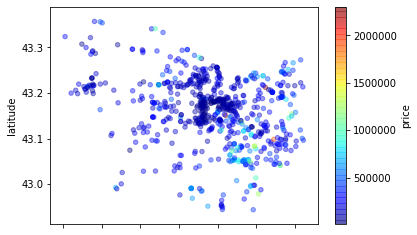

In [11]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,  
             c="price", cmap=plt.get_cmap("jet"), colorbar=True);

## (Pearson's) Correlation coefficient 
* Varies between -1 and 1
* Defined for two random variables (two columns)
* Measures whether there is a  linear relation between two variables
* Does not capture non-linear relations (bottom row)

In [12]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708 entries, 120 to 37
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   708 non-null    float64
 1   longitude  708 non-null    float64
 2   bedrooms   708 non-null    float64
 3   bathrooms  708 non-null    float64
 4   space      708 non-null    float64
 5   price      708 non-null    float64
dtypes: float64(6)
memory usage: 38.7 KB


In [13]:
corr_matrix = housing.corr()
corr_matrix

,latitude,longitude,bedrooms,bathrooms,space,price
latitude,1.000000,-0.275315,-0.143182,-0.219203,-0.211536,-0.240912
longitude,-0.275315,1.000000,0.090997,0.151425,0.170114,0.230264
bedrooms,-0.143182,0.090997,1.000000,0.562030,0.664386,0.379686
bathrooms,-0.219203,0.151425,0.562030,1.000000,0.811419,0.669259
space,-0.211536,0.170114,0.664386,0.811419,1.000000,0.747980
price,-0.240912,0.230264,0.379686,0.669259,0.747980,1.000000


In [14]:
corr_matrix["price"].sort_values(ascending=False)

price        1.000000
space        0.747980
bathrooms    0.669259
bedrooms     0.379686
longitude    0.230264
latitude    -0.240912
Name: price, dtype: float64

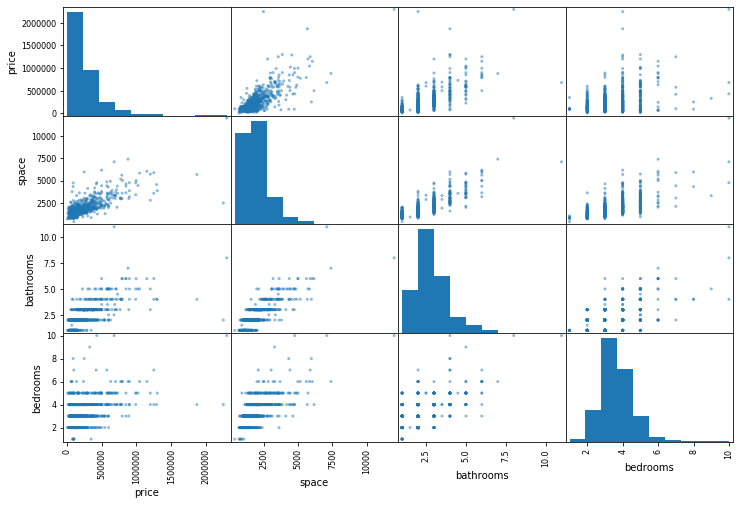

In [15]:
from pandas.plotting import scatter_matrix
attributes=["price","space","bathrooms", "bedrooms"]
scatter_matrix(housing[attributes],figsize=(12,8))
pass

* space seems most promising for predicting house price

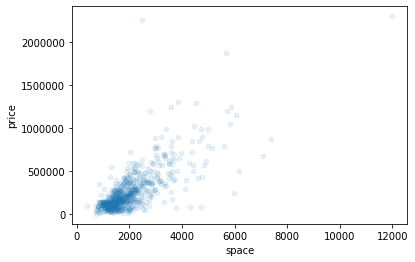

In [16]:
housing.plot(kind='scatter',x="space", y="price", alpha=0.1);

# 4. Prepare the Data for ML Algorithms

## Feature Scaling

* Some algorithms may be sensitive to the scaling of features
* Having one column with values in [0,100000] and another columns whose values are in [0,1]
* 2 commons scaling methods
    - min-max: change range to [0,1] (subtract mean and divide by max-min)
    - standardization: change to 0 mean and 1 standard deviation (subtract mean and divide by standard deviation)

## Min-max scaling

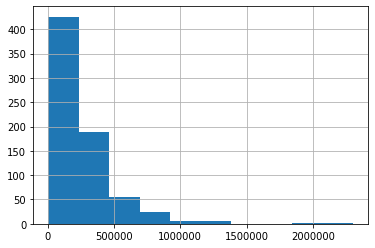

In [17]:
housing["price"].hist();

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(housing[["price"]]).reshape(-1)

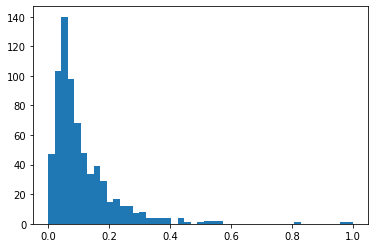

In [19]:
plt.hist(scaled_values, bins='auto') 
pass

## Custom transformers
* sklearn supports custom transformations
* Example: transformer that selects a subset of columns from a dataframe and coverts it to numpy array

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, attibute_names):
        self.attibute_names = attibute_names
    def fit(self, X, y=None):
        return(self)
    def transform(self, X): 
        return(X[self.attibute_names].values)

In [21]:
attibute_list = ['longitude', 'latitude']
df_selector = DataFrameSelector(attibute_list)
df_selector.fit_transform(train_set)

array([[-77.49522 ,  43.186573],
       [-77.73704 ,  43.181202],
       [-77.5676  ,  43.165504],
       ...,
       [-77.39792 ,  43.08258 ],
       [-77.52686 ,  43.123714],
       [-77.43201 ,  43.1309  ]])

In [22]:
len(train_set[attibute_list])

708

## Pipelines
* scikit learn allows creating pipelines that manage flow of data
* Pipelines invoke transformations consecutively
* [Diagram]

In [23]:
# reminder
housing = train_set.copy().drop("price", axis=1)
housing_labels = train_set["price"].copy()

In [24]:
housing.head()

,latitude,longitude,bedrooms,bathrooms,space
120,43.186573,-77.49522,3.0,3.0,2197.0
279,43.181202,-77.73704,3.0,2.0,1594.0
893,43.165504,-77.56760,4.0,1.0,1448.0
506,43.232430,-77.92584,3.0,2.0,1254.0
627,43.185703,-77.58610,5.0,1.0,1400.0


In [25]:
from sklearn.pipeline import Pipeline

num_attributes = ['latitude','longitude','bedrooms','bathrooms','space']

num_pipeline = Pipeline([
    #transformer that selects a subset of columns from a dataframe and coverts it to numpy array
    ('selector',DataFrameSelector(num_attributes)),
    #标准化
    ('MinMax_scaler', MinMaxScaler()),])

housing_prepared = num_pipeline.fit_transform(housing)
housing_prepared.shape

(708, 5)

# 5. Model selection

* We are now ready to train and select models

In [26]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

# 6. Evaluate performance

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.decomposition import PCA
# from sklearn.neighbors import KNeighborsRegressor

In [29]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
print("Linear Regression R^2 Score: ", lin_reg.score(housing_prepared, housing_labels))
housing_predictions = lin_reg.predict(housing_prepared)
print("Root Mean Square Error: ", np.sqrt(mean_squared_error(housing_labels, housing_predictions)))
print("Mean Absolute Error: ", mean_absolute_error(housing_labels, housing_predictions))
print("Cross Validation Score: ", cross_val_score(lin_reg, housing_prepared, housing_labels, cv=5))

Linear Regression R^2 Score:  0.6096095157524606
Root Mean Square Error:  153213.12140872626
Mean Absolute Error:  91545.31038183937
Cross Validation Score:  [0.72262346 0.66528885 0.57092577 0.37328183 0.70241191]


In [30]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
print("Decision Tree R^2 Score: ", tree_reg.score(housing_prepared, housing_labels))
housing_predictions = tree_reg.predict(housing_prepared)
print("Root Mean Square Error: ", np.sqrt(mean_squared_error(housing_labels, housing_predictions)))
print("Mean Absolute Error: ", mean_absolute_error(housing_labels, housing_predictions))
print("Cross Validation Score: ", cross_val_score(tree_reg, housing_prepared, housing_labels, cv=5))

Decision Tree R^2 Score:  0.9999732974720184
Root Mean Square Error:  1267.133983078919
Mean Absolute Error:  78.38983050847457
Cross Validation Score:  [0.27088305 0.63495218 0.12719979 0.36136865 0.5267459 ]


DecisionTree is the highest performing model amongst all used with the accuracy of 99% on the training dataset.

# 7.Now predict the price!

43.2498635,-77.627453,17
4 beds, 1 bath
1306 square feet

In [31]:
data = {'latitude':[43.2498635], 
        'longitude':[-77.627453], 
        'bedrooms':[4], 
        'bathrooms':[1],
        'space':[1306]}
target_feature = pd.DataFrame(data)

In [32]:
target_feature_prepared = num_pipeline.transform(target_feature)
target_feature_prepared
print("Predictions:", tree_reg.predict(target_feature_prepared))

Predictions: [124900.]
